In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
from datetime import date
from prophet import Prophet
import holidays

c:\users\st\desktop\hedranovich\ve\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("powerconsumption.csv")

In [3]:
df

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [4]:
#изменение формата даты с object на datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [5]:
#Добавление  колонок - дата и время. сумма потребления электроэнергии
df['date'] = [d.date() for d in df['Datetime']]
df['time'] = [d.time() for d in df['Datetime']]
df['PC_Sum']=df["PowerConsumption_Zone1"]+df["PowerConsumption_Zone2"]+df["PowerConsumption_Zone3"]

In [19]:
#выделяем таблицу с потреблением электроэнергии и температуры
df_data = ['date','PC_Sum']

In [20]:
df_data=df[df_data]
df_data.head(3)

,date,PC_Sum
0,2017-01-01,70425.53544
1,2017-01-01,69320.84387
2,2017-01-01,67803.22193


In [60]:
# праздники
holidays_dict = holidays.MA(years=(2017))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays

,ds,holiday
0,2017-01-01,Nouvel an - Premier janvier
1,2017-01-11,Commémoration de la présentation du manifeste ...
2,2017-05-01,Fête du Travail
3,2017-06-25,Eid al-Fitr
4,2017-06-26,Eid al-Fitr
5,2017-07-30,Fête du Trône
6,2017-08-14,Journée de Oued Ed-Dahab
7,2017-08-20,Commémoration de la révolution du Roi et du pe...
8,2017-08-21,Fête de la jeunesse
9,2017-09-01,Eid al-Adha


In [79]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 30

# Отрезаем из обучающей выборки последние 30 дней, чтобы измерить на них качество
train_df = df_data[:-predictions]

In [80]:
train_df 

,date,PC_Sum
0,2017-01-01,70425.53544
1,2017-01-01,69320.84387
2,2017-01-01,67803.22193
3,2017-01-01,65489.23209
4,2017-01-01,63650.44627
...,...,...
52381,2017-12-30,87629.80448
52382,2017-12-30,87441.37947
52383,2017-12-30,87464.74256
52384,2017-12-30,87274.99529


In [81]:
train_df.rename(columns = {'date' : 'ds', 'PC_Sum' : 'y'}, inplace = True)
train_df

C:\Users\st\AppData\Local\Temp\ipykernel_8024\187709017.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,2017-01-01,70425.53544
1,2017-01-01,69320.84387
2,2017-01-01,67803.22193
3,2017-01-01,65489.23209
4,2017-01-01,63650.44627
...,...,...
52381,2017-12-30,87629.80448
52382,2017-12-30,87441.37947
52383,2017-12-30,87464.74256
52384,2017-12-30,87274.99529


In [33]:
train_df = train_df[:-predictions]
train_df

,ds,y
0,2017-01-01,70425.53544
1,2017-01-01,69320.84387
2,2017-01-01,67803.22193
3,2017-01-01,65489.23209
4,2017-01-01,63650.44627
...,...,...
52351,2017-12-30,67478.85765
52352,2017-12-30,67611.21663
52353,2017-12-30,67334.56988
52354,2017-12-30,66702.05176


In [82]:
m = Prophet()
m.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [83]:
#Настраиваем prophet, учитываем праздники и сезонности
m = Prophet(holidays = df_holidays, daily_seasonality = True, weekly_seasonality = True, yearly_seasonality = False)
m.fit(train_df)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [84]:
# предсказываем 30 дней
future = m.make_future_dataframe(periods = predictions)
forecast = m.predict(future)

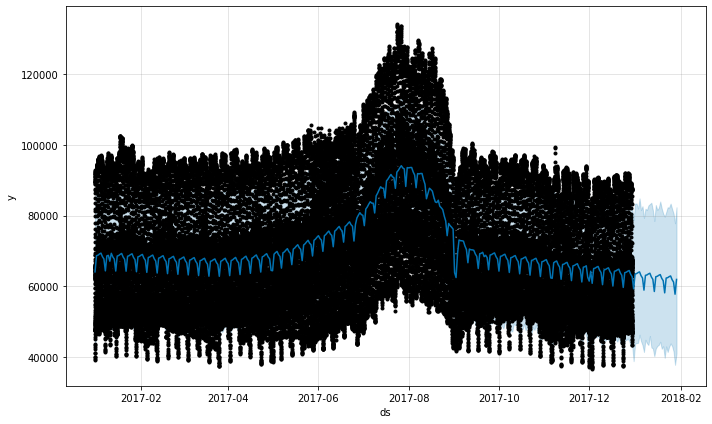

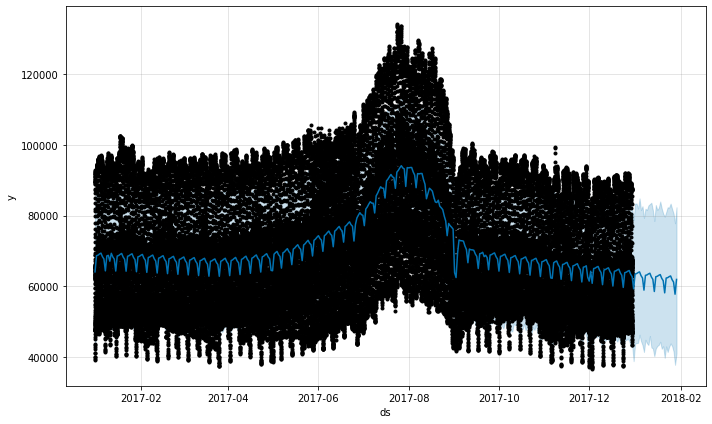

In [85]:
m.plot(forecast)

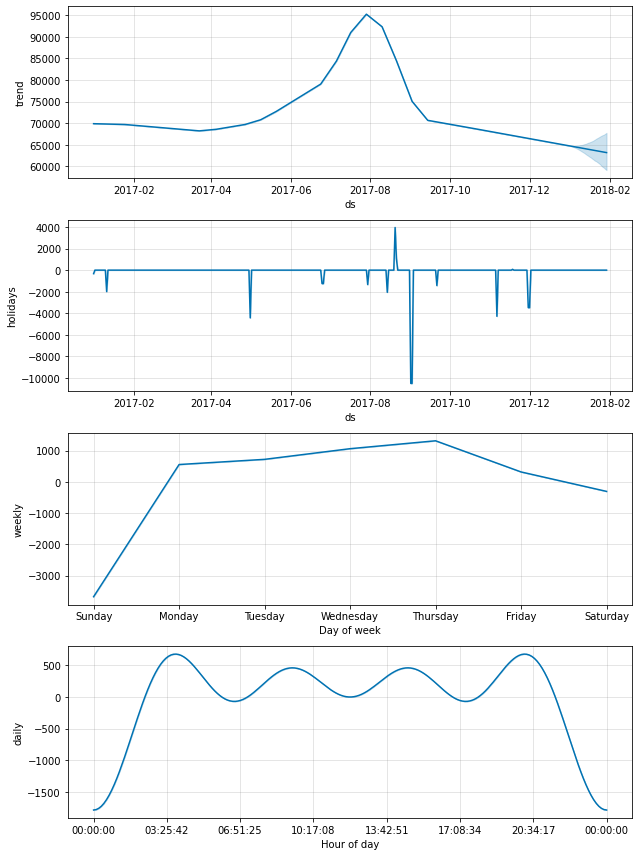

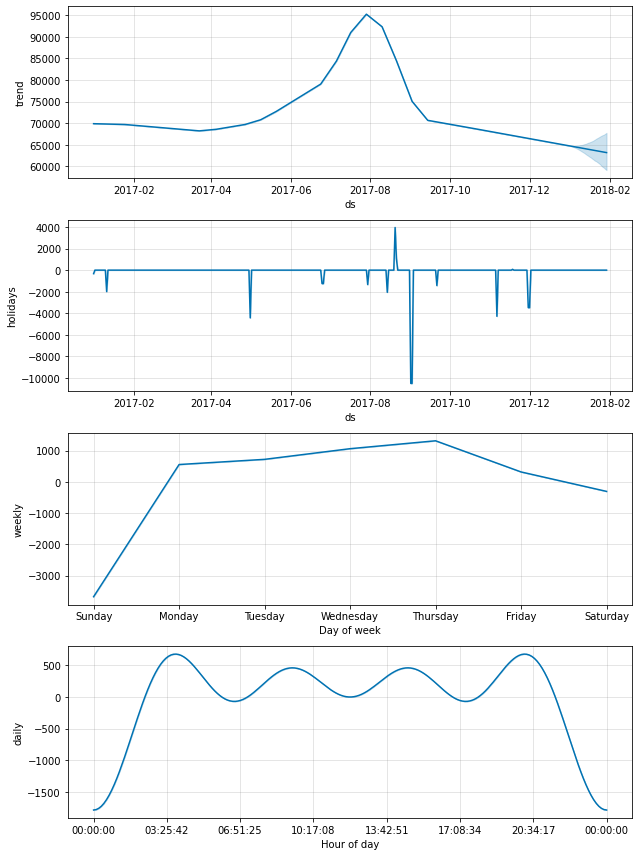

In [86]:
m.plot_components(forecast)